This is a operational simulator for the Foss Toilet - V2.1 for 2 people. 
The aim of this simulator is to establish the best combination of sensors and algorithms to control the levels within the bioreactor (BR) and the flush tank (FT).


First, let's define how to generate a randoms schedule of toilet flushes. The hourly distribution of flushes starts at midnight, and is based on an hourly distribution of flush timings, and an average (Poissonian) distribution of number of flushes per day. 

In [4]:
from typing import List, Optional
import numpy as np
from datetime import datetime, timedelta

def sample_binary_series_from_pmf(
    hourly_pmf: List[float],
    days: int,
    events_per_day: float = 12.0,
    interval_minutes: int = 5,
    seed: Optional[int] = None,
):
    if len(hourly_pmf) != 24:
        raise ValueError("hourly_pmf must have length 24.")
    if interval_minutes <= 0 or 60 % interval_minutes != 0:
        raise ValueError("interval_minutes must evenly divide 60 (e.g., 5, 10, 15, 30).")
    if days <= 0:
        raise ValueError("days must be positive.")
    if events_per_day < 0:
        raise ValueError("events_per_day must be nonnegative.")

    pmf = np.asarray(hourly_pmf, dtype=float)
    if np.any(pmf < 0):
        raise ValueError("hourly_pmf values must be nonnegative.")
    total = pmf.sum()
    if total <= 0:
        raise ValueError("hourly_pmf must have positive total mass.")
    pmf /= total  # normalize to sum to 1 across 24h

    slots_per_hour = 60 // interval_minutes
    slots_per_day = 24 * slots_per_hour
    total_slots = days * slots_per_day

    # Correct per-slot probability: p_slot[h] = 1 - exp(-events_per_day * pmf[h] / slots_per_hour)
    lam_slot_by_hour = events_per_day * pmf / slots_per_hour
    p_slot_by_hour = 1.0 - np.exp(-lam_slot_by_hour)

    # Expand hour-level probs to every slot, then across days
    p_slot_one_day = np.repeat(p_slot_by_hour, slots_per_hour)
    p_slot_full = np.tile(p_slot_one_day, days)

    rng = np.random.default_rng(seed)
    values = rng.binomial(1, p_slot_full).astype(int)
    return values.tolist()
    

Next, we define here a simulation of the tank levels of the bioreactor and the flush tank dynamics, based on a flush schedule, and the control software which defines how fluid is moved between tanks, and into and out of the system. 

In [6]:
from __future__ import annotations
from dataclasses import dataclass, field
from enum import Enum, auto
from typing import Dict, Tuple, Callable, List, Optional, Any
import random

# -----------------------------
# Discrete levels & composite state
# -----------------------------

class Level(Enum):
    LOW = auto()
    NORMAL = auto()
    HIGH = auto()

@dataclass(frozen=True)
class CompositeState:
    br: Level  # bioreactor status
    ft: Level  # flush-tank status

# -----------------------------
# Domain types
# -----------------------------

@dataclass
class Tank:
    name: str
    level: float
    capacity: float
    def add(self, amount: float) -> None:
        self.level = min(self.capacity, max(0.0, self.level + amount))

@dataclass
class StepResult:
    t: int
    dt_min: float
    state: CompositeState
    bioreactor_level: float
    flush_level: float
    flush_event: bool
    info: Dict[str, Any] = field(default_factory=dict)

# -----------------------------
# Config
# -----------------------------

@dataclass
class DynamicsConfig:
    """
    Units:
      - Levels in liters (L)
      - Rates in liters per minute (L/min)
      - dt in minutes
    """
    dt_min: float = 5.0

    # Thresholds (fractions of capacity)
    br_low_thresh: float = 0.25
    br_high_thresh: float = 0.8
    ft_low_thresh: float = 0.1
    ft_high_thresh: float = 0.9

    # Discrete event effect
    flush_bioreactor_L: float = 0.88
    flush_bolus_L: float = 0.25

    #Base rates calculation from physics
    

    # Base rates per composite state:
    #   key = CompositeState(br_level, ft_level)
    #   value = (br_rate_L_per_min, ft_rate_L_per_min)
    base_rates_L_per_min: Dict[CompositeState, Tuple[float, float]] = field(
        default_factory=lambda: {
            CompositeState(Level.LOW,    Level.LOW):    (+0.00, +0.00),
            CompositeState(Level.LOW,    Level.NORMAL): (+0.00, +0.00),
            CompositeState(Level.LOW,    Level.HIGH):   (+0.00, +0.00),

            CompositeState(Level.NORMAL, Level.LOW):    (-0.0051, +0.0044),
            CompositeState(Level.NORMAL, Level.NORMAL): (-0.0051, +0.0044),
            CompositeState(Level.NORMAL, Level.HIGH):   (-0.0051, +0.00),

            CompositeState(Level.HIGH,   Level.LOW):    (-0.0051, +0.0044),
            CompositeState(Level.HIGH,   Level.NORMAL): (-0.0051, +0.0044),
            CompositeState(Level.HIGH,   Level.HIGH):   (-0.0051, +0.00),
        }
    )

# -----------------------------
# Flush schedules (event sources)
# -----------------------------

FlushSchedule = Callable[[int], bool]

def bernoulli_flush_schedule(p: float, seed: Optional[int] = None) -> FlushSchedule:
    rng = random.Random(seed)
    def _sched(t: int) -> bool:
        return rng.random() < p
    return _sched

def series_flush_schedule(series: List[int]) -> FlushSchedule:
    def _sched(t: int) -> bool:
        return 0 <= t < len(series) and bool(series[t])
    return _sched



# --- Level adjustments (liters per step) ---
LevelAdjustment = Callable[[CompositeState, Tank, Tank, DynamicsConfig], Tuple[float, float]]

def no_level_adjustment(state: CompositeState, br: Tank, ft: Tank, cfg: DynamicsConfig) -> Tuple[float, float]:
    """Default controller: no direct level change."""
    return (0.0, 0.0)

def transfer_ft_to_br(state: CompositeState, br: Tank, ft: Tank, cfg: DynamicsConfig):
    if state.br is Level.LOW and state.ft is Level.HIGH and ft.level >= 1.0:
        xfer = 1.0  # liters this step
        # ensure we don't underflow FT or overflow BR; the Tank.add clamp also protects
        xfer = min(xfer, ft.level, br.capacity - br.level)
        return (+xfer, -xfer)
    return (0.0, 0.0)

# -----------------------------
# Simulator
# -----------------------------

class Simulator:
    def __init__(
        self,
        bioreactor: Tank,
        flush_tank: Tank,
        cfg: DynamicsConfig,
        flush_schedule: FlushSchedule,
        level_adjustment: LevelAdjustment = no_level_adjustment,  # <-- changed name/type
    ):
        self.br = bioreactor
        self.ft = flush_tank
        self.cfg = cfg
        self.flush_schedule = flush_schedule
        self.level_adjustment = level_adjustment
        self.t = 0
    
    # ---- Helpers to classify levels ----
    def _level_to_state(self, frac: float, low: float, high: float) -> Level:
        if frac <= low:
            return Level.LOW
        if frac >= high:
            return Level.HIGH
        return Level.NORMAL

    def compute_state(self) -> CompositeState:
        br_frac = (self.br.level / self.br.capacity) if self.br.capacity > 0 else 0.0
        ft_frac = (self.ft.level / self.ft.capacity) if self.ft.capacity > 0 else 0.0
        br_state = self._level_to_state(br_frac, self.cfg.br_low_thresh, self.cfg.br_high_thresh)
        ft_state = self._level_to_state(ft_frac, self.cfg.ft_low_thresh, self.cfg.ft_high_thresh)
        return CompositeState(br=br_state, ft=ft_state)
    
    #-----
    def step(self) -> StepResult:
        cfg = self.cfg
        state = self.compute_state()
        flush_event = self.flush_schedule(self.t)

        # 1) Base continuous dynamics
        br_rate, ft_rate = cfg.base_rates_L_per_min.get(state, (0.0, 0.0))
        br_delta = br_rate * cfg.dt_min
        ft_delta = ft_rate * cfg.dt_min

        # 2) Discrete flush
        info = {"br_rate": br_rate, "ft_rate": ft_rate}
        if flush_event:
            br_delta += cfg.flush_bioreactor_L + cfg.flush_bolus_L
            info["flush_bolus_L"] = cfg.flush_bolus_L
            ft_delta -= cfg.flush_bioreactor_L

        # 3) Controller: direct level adjustments (liters per step)
        dbr_lvl, dft_lvl = self.level_adjustment(state, self.br, self.ft, cfg)
        info["ctrl_level_adj_br_L"] = dbr_lvl
        info["ctrl_level_adj_ft_L"] = dft_lvl
        br_delta += dbr_lvl
        ft_delta += dft_lvl

        # 4) Apply with clamping
        self.br.add(br_delta)
        self.ft.add(ft_delta)

        rec = StepResult(
            t=self.t,
            dt_min=cfg.dt_min,
            state=state,
            bioreactor_level=self.br.level,
            flush_level=self.ft.level,
            flush_event=flush_event,
            info=info,
        )
        self.t += 1
        return rec


    def run(self, steps: int) -> List[StepResult]:
        return [self.step() for _ in range(steps)]



Now, we will generate a flush schedule, and then run the simulation. 

Done. Final BR=20.47 L, FT=11.93 L.


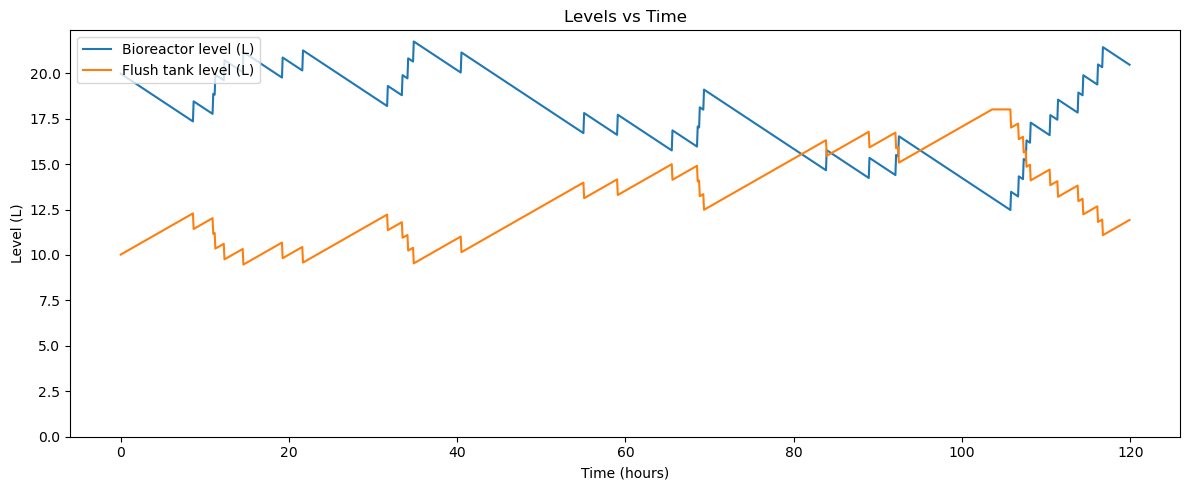

In [9]:
# -----------------------------
# Generate a flush schedule
# -----------------------------
hourly_pmf = [0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]
flush_schedule = sample_binary_series_from_pmf(hourly_pmf,days = 5,events_per_day=8)

#import matplotlib.pyplot as plt
#plt.plot(flush_schedule)

# -----------------------------
# Run Simulation
# -----------------------------
if __name__ == "__main__":
    # Tanks
    br = Tank(name="Bioreactor", level=20.0, capacity=50.0)
    ft = Tank(name="Flush",     level=10.0, capacity=20.0)

    # Config (5-minute timestep)
    cfg = DynamicsConfig(
        dt_min=5.0,
        # You can customize base_rates_L_per_min here if needed
    )

    # Random flushes (~3/day at 5-min steps -> p = 3 / 288)
    p_per_step = 3.0 / (24 * 60 / cfg.dt_min)
    #flush_sched = bernoulli_flush_schedule(p=p_per_step, seed=42)
    flush_sched = series_flush_schedule(flush_schedule)
    number_steps = len(flush_schedule)

    sim = Simulator(
        bioreactor=br,
        flush_tank=ft,
        cfg=cfg,
        flush_schedule=flush_sched,
        level_adjustment = transfer_ft_to_br
    )

    steps =  number_steps # 1 day at 5-min resolution
    hist = sim.run(steps)
    print(f"Done. Final BR={hist[-1].bioreactor_level:.2f} L, FT={hist[-1].flush_level:.2f} L.")


# -----------------------------
# Plot the output
# -----------------------------
import matplotlib.pyplot as plt
import pandas as pd

def history_to_df(history):
    """Convert a list of StepResult into a tidy DataFrame."""
    if not history:
        raise ValueError("history is empty.")
    dt_min = history[0].dt_min
    data = []
    for rec in history:
        # Pull optional info safely
        br_rate = rec.info.get("br_rate")
        ft_rate = rec.info.get("ft_rate")
        ctrl_br = rec.info.get("ctrl_level_adj_br_L")
        ctrl_ft = rec.info.get("ctrl_level_adj_ft_L")
        flush_bolus = rec.info.get("flush_bolus_L")

        data.append({
            "t_step": rec.t,
            "t_min": rec.t * dt_min,
            "t_hr": rec.t * dt_min / 60.0,
            "br_level": rec.bioreactor_level,
            "ft_level": rec.flush_level,
            "flush_event": int(bool(rec.flush_event)),
            "state_br": getattr(rec.state, "br").name if hasattr(rec.state, "br") else None,
            "state_ft": getattr(rec.state, "ft").name if hasattr(rec.state, "ft") else None,
            "br_rate": br_rate,
            "ft_rate": ft_rate,
            "ctrl_level_adj_br_L": ctrl_br,
            "ctrl_level_adj_ft_L": ctrl_ft,
            "flush_bolus_L": flush_bolus,
        })
    return pd.DataFrame(data)

def plot_all_together(df: pd.DataFrame, show_flush_events: bool = True):
    plt.figure(figsize=(12, 5))

    # Main lines: BR and FT levels
    plt.plot(df["t_hr"], df["br_level"], label="Bioreactor level (L)")
    plt.plot(df["t_hr"], df["ft_level"], label="Flush tank level (L)")

    plt.title("Levels vs Time")
    plt.xlabel("Time (hours)")
    plt.ylabel("Level (L)")
    plt.ylim(bottom=0)

    if show_flush_events:
        if "flush_event" not in df.columns:
            raise ValueError("DataFrame missing 'flush_event' column needed for flush events.")
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        markerline, stemlines, baseline = ax2.stem(
            df["t_hr"], df["flush_event"], basefmt=" ", label="Flush event"
        )
        ax2.set_ylabel("Flush event")
        ax2.set_ylim(-0.1, 1.1)
        # Add this so flush events also show up in the legend
        ax2.legend(loc="upper right")

    # Legend for levels
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()


#--- example usage --#
df = history_to_df(hist)
plot_all_together(df, show_flush_events=False)

Now simulate a high usage scenario, with average 12 flushes per day. 

Done. Final BR=42.04 L, FT=0.59 L.


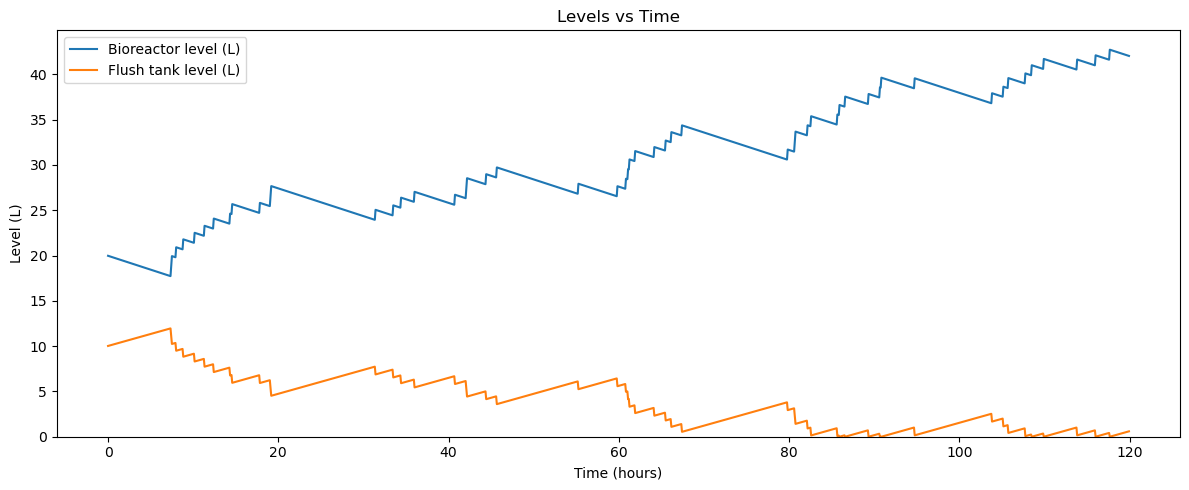

In [12]:
flush_schedule = sample_binary_series_from_pmf(hourly_pmf,days = 5,events_per_day=12)
br = Tank(name="Bioreactor", level=20.0, capacity=50.0)
ft = Tank(name="Flush",     level=10.0, capacity=20.0)
# Config (5-minute timestep)
cfg = DynamicsConfig(    dt_min=5.0,
)
flush_sched = series_flush_schedule(flush_schedule)
number_steps = len(flush_schedule)

sim = Simulator(
    bioreactor=br,
    flush_tank=ft,
    cfg=cfg,
    flush_schedule=flush_sched,
    level_adjustment = transfer_ft_to_br
)
steps =  number_steps # days in 5-min resolution
hist = sim.run(steps)
print(f"Done. Final BR={hist[-1].bioreactor_level:.2f} L, FT={hist[-1].flush_level:.2f} L.")
df = history_to_df(hist)
plot_all_together(df, show_flush_events=False)

Now simulate a low-usage scenario, with average 4 flushes per day. 

Done. Final BR=13.11 L, FT=17.34 L.


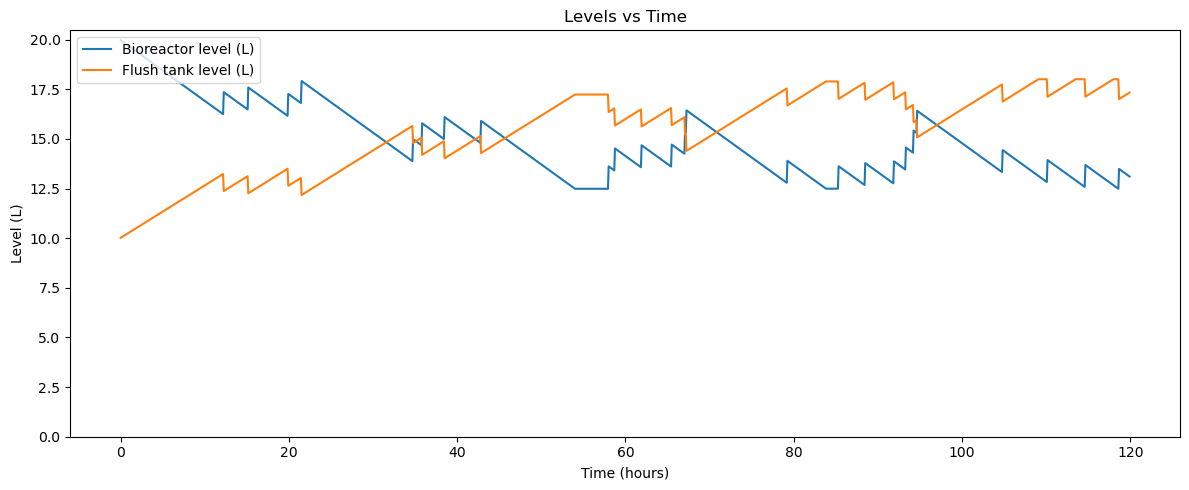

In [13]:
flush_schedule = sample_binary_series_from_pmf(hourly_pmf,days = 5,events_per_day=4)
br = Tank(name="Bioreactor", level=20.0, capacity=50.0)
ft = Tank(name="Flush",     level=10.0, capacity=20.0)
# Config (5-minute timestep)
cfg = DynamicsConfig(    dt_min=5.0,
)
flush_sched = series_flush_schedule(flush_schedule)
number_steps = len(flush_schedule)

sim = Simulator(
    bioreactor=br,
    flush_tank=ft,
    cfg=cfg,
    flush_schedule=flush_sched,
    level_adjustment = transfer_ft_to_br
)
steps =  number_steps # days in 5-min resolution
hist = sim.run(steps)
print(f"Done. Final BR={hist[-1].bioreactor_level:.2f} L, FT={hist[-1].flush_level:.2f} L.")
df = history_to_df(hist)
plot_all_together(df, show_flush_events=False)